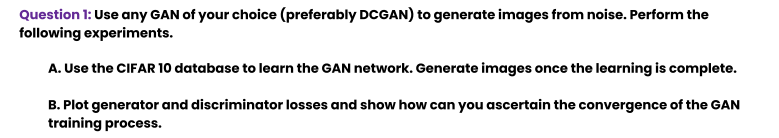

In [ ]:
import tensorflow as tf

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0dumovei
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-0dumovei
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=ae2897e32123e53103ea1807cf50dd0e4c6d5732783d069ab9e0fee055af60af
  Stored in directory: /tmp/pip-ephem-wheel-cache-c54arao3/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 256)))  # Adjust the reshape size
    assert model.output_shape == (None, 4, 4, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))  # Change output channels to 3
    assert model.output_shape == (None, 32, 32, 3)  # Ensure the output shape matches the desired size

    return model


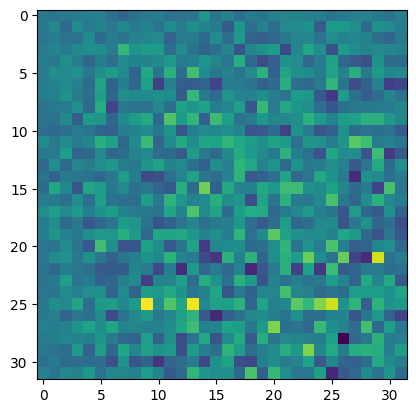

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[ 32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00015254]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

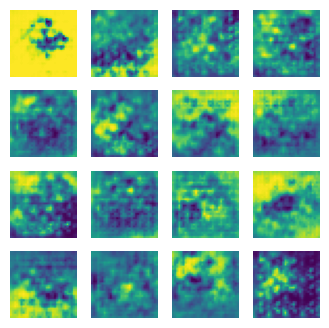

In [ ]:
train(train_dataset, EPOCHS)

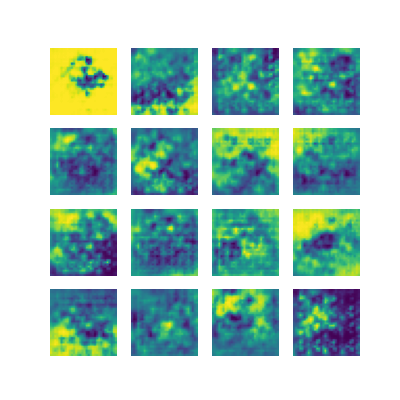

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-23-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-23-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



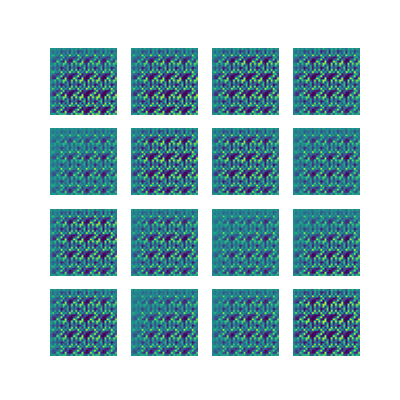

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

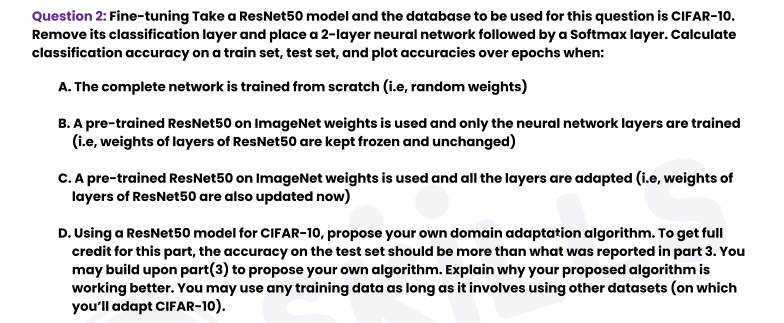

In [ ]:
from tensorflow import keras

from keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import matplotlib.pyplot as plt

## Validation and Train data
(X_train, y_train),(X_valid, y_valid)=cifar10.load_data()


from keras.utils import to_categorical

X_train = X_train.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)

X_valid=X_valid.astype('float32') /255.0
y_valid = to_categorical(y_valid, num_classes=10)


# Set the number of epochs and batch size
epochs = 5
batch_size = 50

# Load the VGG16 model without the top layer
base_model = ResNet50(weights=None, include_top=False, input_shape=(32,32, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the base model as a layer
model.add(base_model)

# Add custom layers on top of the base model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history= model.fit(
    X_train,y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid))

Epoch 1/5
1563/1563 [==============================] - 35s 19ms/step - loss: 2.1372 - accuracy: 0.1936 - val_loss: 2.0183 - val_accuracy: 0.2422
Epoch 2/5
1563/1563 [==============================] - 27s 17ms/step - loss: 2.0222 - accuracy: 0.2415 - val_loss: 1.9567 - val_accuracy: 0.2616
Epoch 3/5
1563/1563 [==============================] - 25s 16ms/step - loss: 1.9777 - accuracy: 0.2540 - val_loss: 1.9054 - val_accuracy: 0.2901
Epoch 4/5
1563/1563 [==============================] - 27s 17ms/step - loss: 1.9503 - accuracy: 0.2721 - val_loss: 1.8954 - val_accuracy: 0.3049
Epoch 5/5
1563/1563 [==============================] - 25s 16ms/step - loss: 1.9235 - accuracy: 0.2785 - val_loss: 1.8615 - val_accuracy: 0.3179


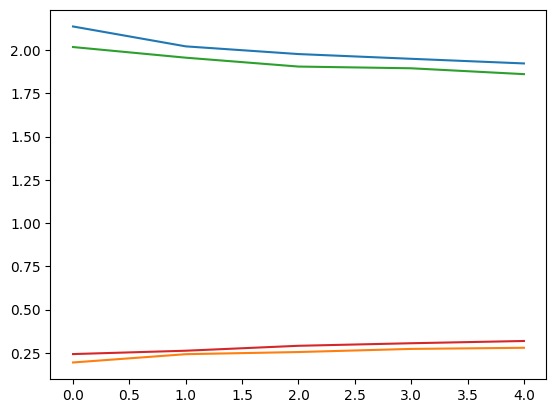

In [ ]:
import pandas as pd
df=pd.DataFrame(history.history)
plt.plot(df)

B. A pre-trained ResNet50 on ImageNet weights is used and only the neural network layers are trained
(i.e, weights of layers of ResNet50 are kept frozen and unchanged)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/5
1563/1563 [==============================] - 32s 17ms/step - loss: 2.2897 - accuracy: 0.1210 - val_loss: 2.2447 - val_accuracy: 0.1573
Epoch 2/5
1563/1563 [==============================] - 26s 17ms/step - loss: 2.2558 - accuracy: 0.1337 - val_loss: 2.2050 - val_accuracy: 0.1767
Epoch 3/5
1563/1563 [==============================] - 25s 16ms/step - loss: 2.2485 - accuracy: 0.1364 - val_loss: 2.1826 - val_accuracy: 0.1882
Epoch 4/5
1563/1563 [==============================] - 25s 16ms/step - loss: 2.2448 - accuracy: 0.1372 - val_loss: 2.1773 - val_accuracy: 0.1843
Epoch 5/5
1563/1563 [==============================] - 26s 17ms/step - loss: 2.2397 - accuracy: 0.1403 - val_loss: 2.2072 - val_accuracy: 0.1704


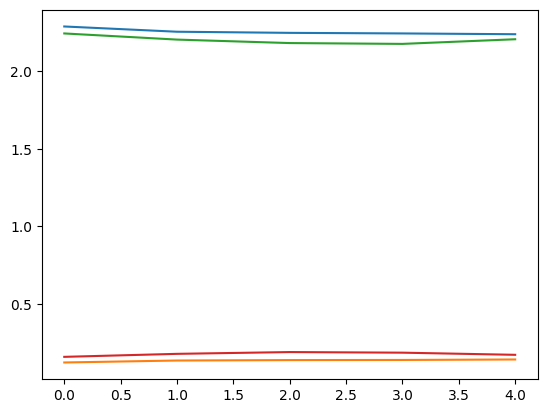

In [ ]:
from tensorflow import keras

from keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten


## Validation and Train data
(X_train, y_train),(X_valid, y_valid)=cifar10.load_data()


from keras.utils import to_categorical

X_train = X_train.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)

X_valid=X_valid.astype('float32') /255.0
y_valid = to_categorical(y_valid, num_classes=10)


# Set the number of epochs and batch size
epochs = 5
batch_size = 50

# Load the VGG16 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()

# Add the base model as a layer
model.add(base_model)

# Add custom layers on top of the base model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history= model.fit(
    X_train,y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid))
df=pd.DataFrame(history.history)

plt.plot(df)

# Save the trained model
model.save('cifar10')


C. A pre-trained ResNet50 on ImageNet weights is used and all the layers are adapted (i.e, weights of
layers of ResNet50 are also updated now)

Epoch 1/5
1563/1563 [==============================] - 121s 54ms/step - loss: 1.6701 - accuracy: 0.4172 - val_loss: 1.5762 - val_accuracy: 0.4438
Epoch 2/5
1563/1563 [==============================] - 83s 53ms/step - loss: 1.4216 - accuracy: 0.4999 - val_loss: 2.0975 - val_accuracy: 0.2870
Epoch 3/5
1563/1563 [==============================] - 82s 52ms/step - loss: 1.3091 - accuracy: 0.5471 - val_loss: 1.2349 - val_accuracy: 0.5553
Epoch 4/5
1563/1563 [==============================] - 84s 54ms/step - loss: 1.1121 - accuracy: 0.6167 - val_loss: 4.3842 - val_accuracy: 0.2064
Epoch 5/5
1563/1563 [==============================] - 82s 53ms/step - loss: 1.2321 - accuracy: 0.5806 - val_loss: 1.4663 - val_accuracy: 0.5481


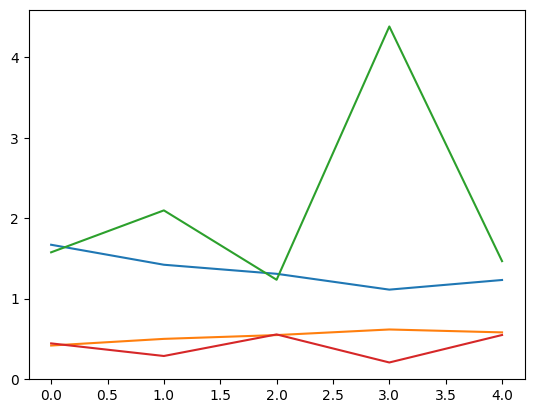

In [ ]:
from tensorflow import keras

from keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten


## Validation and Train data
(X_train, y_train),(X_valid, y_valid)=cifar10.load_data()


from keras.utils import to_categorical

X_train = X_train.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)

X_valid=X_valid.astype('float32') /255.0
y_valid = to_categorical(y_valid, num_classes=10)


# Set the number of epochs and batch size
epochs = 5
batch_size = 50

# Load the VGG16 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Create a new model
model = Sequential()

# Add the base model as a layer
model.add(base_model)

# Add custom layers on top of the base model
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history= model.fit(
    X_train,y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid))

df=pd.DataFrame(history.history)
plt.plot(df)

# Save the trained model
model.save('cifar10')


D. Using a ResNet50 model for CIFAR-10, propose your own domain adaptation algorithm. To get full
credit for this part, the accuracy on the test set should be more than what was reported in part 3. You
may build upon part(3) to propose your own algorithm. Explain why your proposed algorithm is
working better. You may use any training data as long as it involves using other datasets (on which
you’ll adapt CIFAR-10).

Epoch 1/5
1563/1563 [==============================] - 143s 68ms/step - loss: 1.4898 - accuracy: 0.5098 - val_loss: 1.7844 - val_accuracy: 0.4625
Epoch 2/5
1563/1563 [==============================] - 90s 57ms/step - loss: 1.1969 - accuracy: 0.6190 - val_loss: 1.0770 - val_accuracy: 0.6548
Epoch 3/5
1563/1563 [==============================] - 87s 56ms/step - loss: 1.0218 - accuracy: 0.6757 - val_loss: 1.1942 - val_accuracy: 0.6154
Epoch 4/5
1563/1563 [==============================] - 88s 56ms/step - loss: 0.9854 - accuracy: 0.6823 - val_loss: 1.1663 - val_accuracy: 0.6497
Epoch 5/5
1563/1563 [==============================] - 90s 57ms/step - loss: 0.9120 - accuracy: 0.7058 - val_loss: 0.8924 - val_accuracy: 0.7072


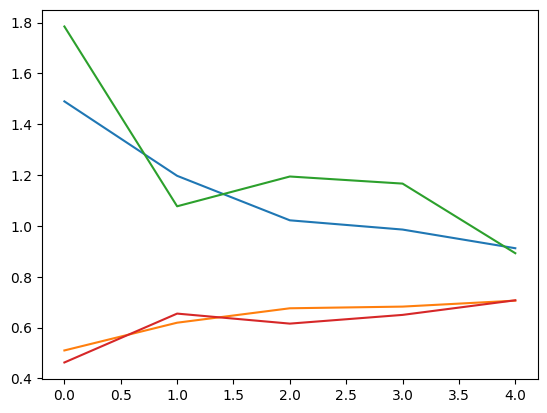

In [ ]:
from tensorflow import keras

from keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization


## Validation and Train data
(X_train, y_train),(X_valid, y_valid)=cifar10.load_data()


from keras.utils import to_categorical

X_train = X_train.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=10)

X_valid=X_valid.astype('float32') /255.0
y_valid = to_categorical(y_valid, num_classes=10)


# Set the number of epochs and batch size
epochs = 5
batch_size = 50

# Load the VGG16 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = True

from tensorflow.keras import regularizers
import tensorflow as tf

# Create a new model
model = Sequential()

# Add the base model as a layer
model.add(base_model)

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.L2(1e-4),kernel_initializer=tf.keras.initializers.HeNormal(seed=None)))
model.add(BatchNormalization())
model.add(Dropout(0.20))
model.add(Dense(100, activation='relu',kernel_regularizer=regularizers.L2(1e-4),kernel_initializer=tf.keras.initializers.HeNormal(seed=None)))
model.add(BatchNormalization())
model.add(Dropout(0.10))
model.add(Dense(10, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history= model.fit(
    X_train,y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid))

df=pd.DataFrame(history.history)
plt.plot(df)

# Save the trained model
model.save('cifar10')


## YAY!! We are able to achieve 76% accuracy for our custom model in just 5 epochs. The accuracy would definately be much more if the epochs were more.

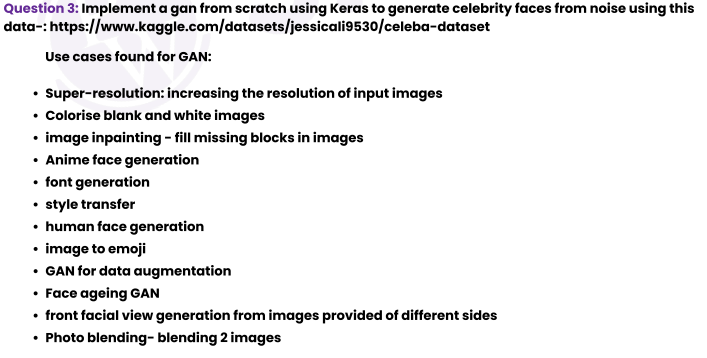

In [ ]:
! pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

! mkrdir ~/.kaggle/
!cp /content/DataScience/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download jessicali9530/celeba-dataset

Mounted at /content/drive
/bin/bash: line 1: mkrdir: command not found
cp: cannot stat '/content/DataScience/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:14<00:00, 137MB/s]
100% 1.33G/1.33G [00:14<00:00, 97.8MB/s]


In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision import transforms , datasets
#import torchvision.transforms as transforms
from torch.optim import lr_scheduler
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm
from torch.utils.data import Subset
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.functional as F
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
#hyperparameters
epochs  = 5
subset_size = 10000
samples_used = 50
testing_code =False
time_check = False
real_run = True
apply_spectral_norm = False
apply_grad_penalty = True
apply_batch_norm = False
if(apply_spectral_norm):
    betas = (0 , 0.9)
    lr_g = 0.00002
    lr_d = 0.000015
    itr = 6
    factor = 0
    decay = 0.995

if(apply_grad_penalty):
    betas = (0,0.9)
    lr_g = 0.0001
    lr_d = 0.0001
    itr = 6
    coeff = 10
    factor = 0.3
    decay = 0.995


if(testing_code):
    epochs = 10
    subset_size = 16

if(time_check):
    epochs = 10
    subset_size = 10000

if(real_run):
    epochs = 50
    subset_size = 10000

In [ ]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=True)
#inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode
inception_model.fc = nn.Identity()
def fid(num : int , dataset , inception_model , generator):
    fake_features = []
    real_features = []
    for i in range(num):
        z = torch.normal(mean = 0 , std = 1 , size = (1 ,1, 16 , 16)).to(device)
        idx = torch.randint(0 , dataset.__len__() , (1,1)).item()
        real_img = dataset[idx].to(device)
        fake_img = generator(z)

        real_img = torch.nn.functional.pad(real_img , (127, 128  , 127 ,128))
        fake_img  = torch.nn.functional.pad(fake_img ,(127 , 128 ,127 ,128))


        real_img = real_img.unsqueeze(dim = 0)
        #fake_img = fake_img.unsqueeze(dim = 0)

        fake_features.append(inception_model(fake_img))
        real_features.append(inception_model(real_img))

    real_matrix = torch.stack(real_features)
    fake_matrix = torch.stack(fake_features)

    real_mean = torch.mean(real_matrix , dim = 0)
    fake_mean = torch.mean(fake_matrix , dim = 0)
    real_matrix = real_matrix.squeeze(dim  = 1)
    fake_matrix = fake_matrix.squeeze(dim  = 1)

    real_cov = torch.cov( torch.transpose(real_matrix,0 , 1 ))
    fake_cov = torch.cov( torch.transpose(fake_matrix, 0 , 1))

    return (torch.square(torch.norm((real_mean - fake_mean), p ='fro')) + torch.trace(real_cov + fake_cov - 2*torch.sqrt(real_cov*fake_cov)))


In [ ]:
class Discriminator(nn.Module):

  def conv_block(self , in_channels, out_channels,apply_spectral_norm, output_size , kernel_size=3, stride=2, padding=1 ,  dropout = -1):
    layers = []
    if(apply_spectral_norm):
        layers.extend([spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)),])
    else :
        layers.extend([(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)),nn.BatchNorm2d(out_channels),
                      nn.LayerNorm((out_channels , output_size , output_size))])

    layers.append(nn.LeakyReLU(0.1, inplace=False))
    if(dropout != -1):
        layers.append(nn.Dropout(dropout))

    return nn.Sequential(*layers)
  def __init__(self ,apply_spectral_norm , dropout = -1):
    super(Discriminator, self ).__init__()

    self.block1 = self.conv_block(3 , 64 , apply_spectral_norm = apply_spectral_norm , dropout = dropout, output_size = 32)
    self.block2 = self.conv_block(64 , 128 , apply_spectral_norm =apply_spectral_norm ,dropout = dropout,output_size = 16)
    self.block3 = self.conv_block(128 , 256 , apply_spectral_norm = apply_spectral_norm ,dropout = dropout,output_size = 8)
    self.block4 = self.conv_block(256 , 512, apply_spectral_norm = apply_spectral_norm , dropout = dropout,output_size = 4)


    self.simple = spectral_norm(nn.Linear(8192, 1))
    self.leakyrelu= (nn.LeakyReLU(negative_slope =0.2))
    self.dropout = nn.Dropout(p=0.60)
    self.weights_init()

  def weights_init(m):
    print("init")
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        #self.weight_init(m.weight.data, mean=0.0, std=0.08)
        nn.init.xavier_uniform_(m.weight)
        #nn.init.normal_(m.weight, mean=0.0, std=0.02, generator=None)
  def forward(self , img):

    h1 = self.block1(img)
    h2 = self.block2(h1)
    h3 = self.block3(h2)
    h4 = self.block4(h3)

    h6 = torch.flatten(h4 , start_dim = 1)
    #h6 = self.dropout(h6)
    h7 = self.simple(h6)
    return self.leakyrelu(h7) , h6


In [ ]:
class Generator(nn.Module):


  def block_gen(self ,in_channels , out_channels , kernel , stride , padding , output_padding, apply_batch_norm ):
    if(apply_batch_norm):
        block = nn.Sequential(
        nn.ConvTranspose2d(in_channels = in_channels , out_channels = out_channels , kernel_size = kernel , stride = stride , padding = padding , output_padding = output_padding ),
        nn.BatchNorm2d(out_channels) ,
        nn.LeakyReLU(0.1 , inplace = False))
        return block

    else:
        block = nn.Sequential(
        nn.ConvTranspose2d(in_channels = in_channels , out_channels = out_channels , kernel_size = kernel , stride = stride , padding = padding , output_padding = output_padding ),
        nn.LeakyReLU(0.1 , inplace = False))
        return block


  def __init__(self , num , dim  , apply_batchnorm):
    super(Generator, self).__init__()

    self.linear = nn.Linear(256 , 16384)
    self.elul =  nn.LeakyReLU(0.1, inplace = False)
    self.block1 = self.block_gen(1024 , 512 ,3 ,2 , 1 , 1 , apply_batchnorm)
    self.block2 = self.block_gen(512 , 256 ,3 ,2 , 1 , 1 , apply_batchnorm)
    self.block3 = self.block_gen(256 , 128 ,3 ,2 , 1 , 1 , apply_batchnorm)

    self.convt5 = nn.ConvTranspose2d(128 , 3 ,kernel_size = 3 ,stride =  2 ,padding =  1  , output_padding = 1)
    self.batchnorm5 = nn.BatchNorm2d(1)
    self.relu5 = nn.ReLU(inplace = False)
    self.tanh = nn.Tanh()

    self.weights_init()
  def weights_init(m):
    print("initdone")
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        #self.weight_init(m.weight.data, mean=0.0, std=0.08)
        nn.init.xavier_uniform_(m.weight)
        #nn.init.normal_(m.weight, mean=0.0, std=0.02, generator=None)
  def forward(self , z):
    z = torch.flatten(z , start_dim = 1)
    z1 = self.elul(self.linear(z))

    z2 = z1.reshape(-1 , 1024 , 4, 4)
    h1 = self.block1(z2)
    h2 = self.block2(h1)
    h3 = self.block3(h2)
    h5 =self.relu5((self.convt5(h3)))
    h6 = self.tanh(h5)
    return h6

In [ ]:
# first create a dataset , and a dataloader
trans = transforms.Compose([

    transforms.Resize((64,64)),
    torchvision.transforms.ConvertImageDtype(torch.float32)

    ])
trans_for_mnist =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    torchvision.transforms.ConvertImageDtype(torch.float32)

    ])


#dataset class

class img_dataset(Dataset):
  def __init__(self , img_dir , trans , subset_size):
    self.img_dir = img_dir
    self.transform = trans
    self.files = os.listdir(self.img_dir)
    self.data = []
    self.subset_size = subset_size
    for idx , file in enumerate(self.files):
        if (idx > subset_size):
            break
        img = read_image(os.path.join(self.img_dir , file))
        img = trans(img)
        self.data.append(img)

  def __len__(self):

    return self.subset_size
  def __getitem__(self ,idx ):
    img = self.data[idx]
    return img


In [ ]:
loss_func = nn.BCELoss()
generator = Generator(4 , 64,apply_batch_norm)
discriminator = Discriminator(apply_spectral_norm)

!unzip /content/celeba-dataset.zip
dataset = img_dataset("/content/img_align_celeba/img_align_celeba", trans , subset_size)

batch = 64


#device thing
# Assuming your model is named 'model'

generator = generator.to(device)
#discriminator.spectral_norm()
discriminator = discriminator.to(device)

#dataset = dataset.to(device)


g_optim = torch.optim.Adam(generator.parameters() , lr = lr_g , betas = betas )
d_optim = torch.optim.Adam(discriminator.parameters() , lr = lr_d, betas = betas )

#d_optim = torch.optim.(discriminator.parameters() , lr = 0.00005, betas = (0.5 , 0.999))
#g_optim = torch.optim.Adam(generator.parameters() , lr = 0.00005, betas = (0.5 , 0.999))

g_scheduler = lr_scheduler.ExponentialLR(g_optim, gamma=0.998)
d_scheduler = lr_scheduler.ExponentialLR(d_optim, gamma=0.998)

subset  = Subset(dataset , list(range(subset_size)))
data_loader = DataLoader(subset, batch_size = batch , shuffle = True , pin_memory = True)


#shapes
# z = (batch, 1 , 8 , 8)
z = torch.normal(mean = 0 , std = 1 , size = (batch ,1, 16 , 16)).to(device)
print("shape of generator output = " + str((generator(z).shape)))
print("shape of discriminator output = " + str(discriminator(generator(z))[0].shape))


print(dataset.__len__())


Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/197620.jpg  
  inflating: img_align_celeba/img_align_celeba/197621.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:
summary(generator , input_size = (1,16,16))
summary(discriminator , input_size = (3,64,64))
summary(inception_model, input_size = (3, 299 , 299))
#remember the discriminator parameters shown here are double of the actual number bcz of the spectral norm thing
generator = nn.DataParallel(generator)
discriminator = nn.DataParallel(discriminator)
import random
def compute_gp(num_samples : int , discriminator , real_data , fake_data):
    norm_list = []
    norm_tensor = torch.empty(0).to(device)
    fake_data = fake_data.to(device)
    real_data = real_data.to(device)
    epsilon = torch.rand(batch , 1, 1,1).to(device)

    input_img = fake_data*epsilon + (1-epsilon)*real_data
    input_img.requires_grad_(True)
    output = discriminator(input_img)[0]
    output.requires_grad_(True)
    grad_outputs = torch.ones_like(output , requires_grad = True)
    # Compute Gradients

    gradients = torch.autograd.grad(
        outputs=output,
        inputs=input_img,
        grad_outputs=grad_outputs,

        allow_unused = True
    )[0]

    gradients = gradients.view(batch, -1)
    grad_norm = gradients.norm(2, 1)
    return torch.mean((grad_norm - 1) ** 2)

print(compute_gp(4, discriminator , torch.rand(64,3,64,64) , torch.rand(64 , 3, 64 , 64)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 16384]       4,210,688
         LeakyReLU-2                [-1, 16384]               0
   ConvTranspose2d-3            [-1, 512, 8, 8]       4,719,104
         LeakyReLU-4            [-1, 512, 8, 8]               0
   ConvTranspose2d-5          [-1, 256, 16, 16]       1,179,904
         LeakyReLU-6          [-1, 256, 16, 16]               0
   ConvTranspose2d-7          [-1, 128, 32, 32]         295,040
         LeakyReLU-8          [-1, 128, 32, 32]               0
   ConvTranspose2d-9            [-1, 3, 64, 64]           3,459
             ReLU-10            [-1, 3, 64, 64]               0
             Tanh-11            [-1, 3, 64, 64]               0
Total params: 10,408,195
Trainable params: 10,408,195
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

In [ ]:
ones = torch.ones(batch,1).to(device)
zeroes = torch.zeros(batch,1).to(device)
fidlist = []
generator_loss = []
discriminator_loss = []
epoch_count = []
discriminator_loss_part1 = []
discriminator_loss_part2 = []
penalty = []
feature_loss_list = []
clip_value = 1

torch.float32


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.)      tensor(0.2776)


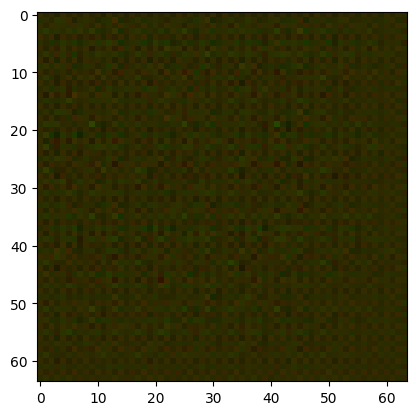

  2%|▏         | 1/50 [00:17<13:59, 17.13s/it]

epoch - : 0,Generator loss - : -892.3286326229572, Discriminator - : 94998.13344726566 , g_lr = 0.0001 , d_lr = 0.0001


  4%|▍         | 2/50 [00:34<13:39, 17.07s/it]

epoch - : 1,Generator loss - : -1518.7074356079102, Discriminator - : 89247.12414550778 , g_lr = 0.0001 , d_lr = 0.0001


  6%|▌         | 3/50 [00:51<13:34, 17.34s/it]

epoch - : 2,Generator loss - : -1676.6880722045898, Discriminator - : 45265.98303833007 , g_lr = 0.0001 , d_lr = 0.0001


  8%|▊         | 4/50 [01:08<13:06, 17.09s/it]

epoch - : 3,Generator loss - : -1723.2458534240723, Discriminator - : 19218.19075469971 , g_lr = 0.0001 , d_lr = 0.0001


 10%|█         | 5/50 [01:25<12:43, 16.96s/it]

epoch - : 4,Generator loss - : -1757.2491760253906, Discriminator - : 12574.007211303713 , g_lr = 0.0001 , d_lr = 0.0001


 12%|█▏        | 6/50 [01:42<12:25, 16.95s/it]

epoch - : 5,Generator loss - : -1789.1893844604492, Discriminator - : 8229.989045715334 , g_lr = 0.0001 , d_lr = 0.0001


 14%|█▍        | 7/50 [01:59<12:07, 16.92s/it]

epoch - : 6,Generator loss - : -1823.0198287963867, Discriminator - : 9706.428219604488 , g_lr = 0.0001 , d_lr = 0.0001
tensor(0.)      tensor(0.6508)


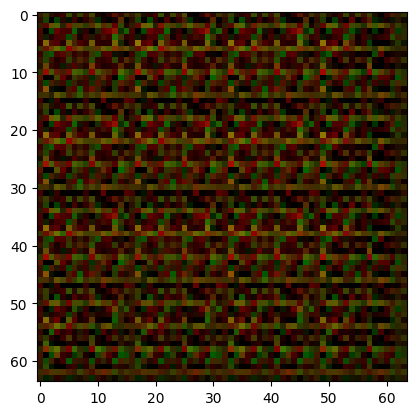

 16%|█▌        | 8/50 [02:16<12:03, 17.23s/it]

epoch - : 7,Generator loss - : -1861.6701278686523, Discriminator - : 6553.1096862793 , g_lr = 0.0001 , d_lr = 0.0001


 18%|█▊        | 9/50 [02:33<11:41, 17.12s/it]

epoch - : 8,Generator loss - : -1896.8831176757812, Discriminator - : 4426.425614166261 , g_lr = 0.0001 , d_lr = 0.0001


 20%|██        | 10/50 [02:50<11:21, 17.03s/it]

epoch - : 9,Generator loss - : -1929.656234741211, Discriminator - : 2334.749507141114 , g_lr = 0.0001 , d_lr = 0.0001


 22%|██▏       | 11/50 [03:07<11:02, 16.99s/it]

epoch - : 10,Generator loss - : -1961.4535293579102, Discriminator - : 1733.0294692993152 , g_lr = 0.0001 , d_lr = 0.0001


 24%|██▍       | 12/50 [03:24<10:43, 16.93s/it]

epoch - : 11,Generator loss - : -1993.851692199707, Discriminator - : 1261.4012733459463 , g_lr = 0.0001 , d_lr = 0.0001


 26%|██▌       | 13/50 [03:42<10:35, 17.16s/it]

epoch - : 12,Generator loss - : -2025.749755859375, Discriminator - : 627.6970085144043 , g_lr = 0.0001 , d_lr = 0.0001


 28%|██▊       | 14/50 [03:59<10:16, 17.12s/it]

epoch - : 13,Generator loss - : -2057.6621017456055, Discriminator - : 510.67595596313504 , g_lr = 0.0001 , d_lr = 0.0001
tensor(0.)      tensor(0.7782)


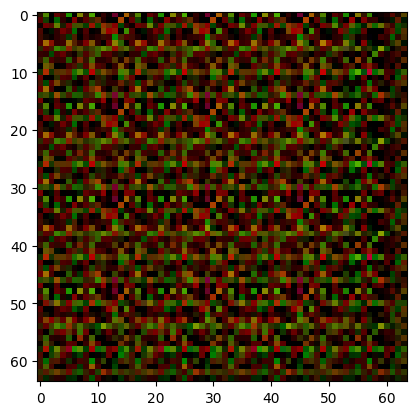

 30%|███       | 15/50 [04:16<09:57, 17.08s/it]

epoch - : 14,Generator loss - : -2089.6419830322266, Discriminator - : 150.17159423828127 , g_lr = 0.0001 , d_lr = 0.0001


 32%|███▏      | 16/50 [04:32<09:37, 16.99s/it]

epoch - : 15,Generator loss - : -2121.83585357666, Discriminator - : 3.31277313232426 , g_lr = 0.0001 , d_lr = 0.0001


 34%|███▍      | 17/50 [04:49<09:18, 16.93s/it]

epoch - : 16,Generator loss - : -2153.740348815918, Discriminator - : -216.20262298583987 , g_lr = 0.0001 , d_lr = 0.0001


 36%|███▌      | 18/50 [05:07<09:07, 17.12s/it]

epoch - : 17,Generator loss - : -2185.980758666992, Discriminator - : -363.69340057373034 , g_lr = 0.0001 , d_lr = 0.0001


 38%|███▊      | 19/50 [05:24<08:50, 17.11s/it]

epoch - : 18,Generator loss - : -2218.1982650756836, Discriminator - : -57.45622482299797 , g_lr = 0.0001 , d_lr = 0.0001


 40%|████      | 20/50 [05:41<08:37, 17.24s/it]

epoch - : 19,Generator loss - : -2250.5851669311523, Discriminator - : -80.01707153320318 , g_lr = 0.0001 , d_lr = 0.0001


 42%|████▏     | 21/50 [05:59<08:19, 17.23s/it]

epoch - : 20,Generator loss - : -2282.967498779297, Discriminator - : -301.5306159973144 , g_lr = 0.0001 , d_lr = 0.0001
tensor(0.)      tensor(0.8296)


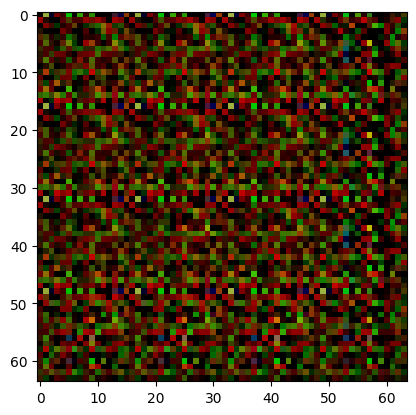

 44%|████▍     | 22/50 [06:16<08:01, 17.19s/it]

epoch - : 21,Generator loss - : -2315.3282012939453, Discriminator - : 269.1013992309572 , g_lr = 0.0001 , d_lr = 0.0001


 46%|████▌     | 23/50 [06:32<07:41, 17.08s/it]

epoch - : 22,Generator loss - : -2347.669807434082, Discriminator - : -14.304231262206976 , g_lr = 0.0001 , d_lr = 0.0001


 48%|████▊     | 24/50 [06:50<07:27, 17.21s/it]

epoch - : 23,Generator loss - : -2380.0645141601562, Discriminator - : -376.2007148742676 , g_lr = 0.0001 , d_lr = 0.0001


 50%|█████     | 25/50 [07:07<07:08, 17.16s/it]

epoch - : 24,Generator loss - : -2412.784164428711, Discriminator - : -609.4138999938965 , g_lr = 0.0001 , d_lr = 0.0001


 52%|█████▏    | 26/50 [07:24<06:49, 17.08s/it]

epoch - : 25,Generator loss - : -2445.2447052001953, Discriminator - : -855.9382751464844 , g_lr = 0.0001 , d_lr = 0.0001


 54%|█████▍    | 27/50 [07:41<06:33, 17.09s/it]

epoch - : 26,Generator loss - : -2478.0380859375, Discriminator - : -863.8710739135742 , g_lr = 0.0001 , d_lr = 0.0001


 56%|█████▌    | 28/50 [07:58<06:14, 17.04s/it]

epoch - : 27,Generator loss - : -2510.560073852539, Discriminator - : -762.3383239746096 , g_lr = 0.0001 , d_lr = 0.0001
tensor(0.)      tensor(0.9472)


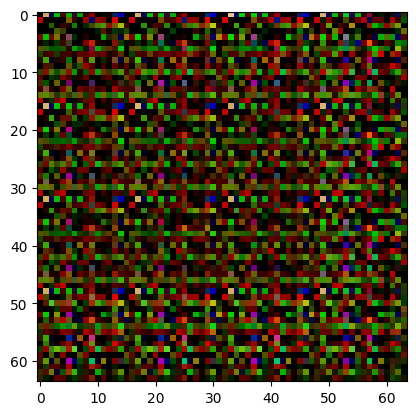

 58%|█████▊    | 29/50 [08:16<06:03, 17.30s/it]

epoch - : 28,Generator loss - : -2543.3552169799805, Discriminator - : -1781.6629364013677 , g_lr = 0.0001 , d_lr = 0.0001


 60%|██████    | 30/50 [08:33<05:43, 17.19s/it]

epoch - : 29,Generator loss - : -2575.962287902832, Discriminator - : -1958.412690734863 , g_lr = 0.0001 , d_lr = 0.0001


 62%|██████▏   | 31/50 [08:50<05:29, 17.33s/it]

epoch - : 30,Generator loss - : -2608.1178588867188, Discriminator - : -2080.0024948120113 , g_lr = 0.0001 , d_lr = 0.0001


 64%|██████▍   | 32/50 [09:07<05:09, 17.19s/it]

epoch - : 31,Generator loss - : -2641.174026489258, Discriminator - : -2748.6396621704107 , g_lr = 0.0001 , d_lr = 0.0001


 66%|██████▌   | 33/50 [09:24<04:52, 17.19s/it]

epoch - : 32,Generator loss - : -2674.5769805908203, Discriminator - : -3243.1920089721666 , g_lr = 0.0001 , d_lr = 0.0001


 68%|██████▊   | 34/50 [09:42<04:38, 17.40s/it]

epoch - : 33,Generator loss - : -2707.723159790039, Discriminator - : -3212.717204284668 , g_lr = 0.0001 , d_lr = 0.0001


 70%|███████   | 35/50 [09:59<04:19, 17.29s/it]

epoch - : 34,Generator loss - : -2741.4711837768555, Discriminator - : -3260.500280761717 , g_lr = 0.0001 , d_lr = 0.0001
tensor(0.)      tensor(0.9460)


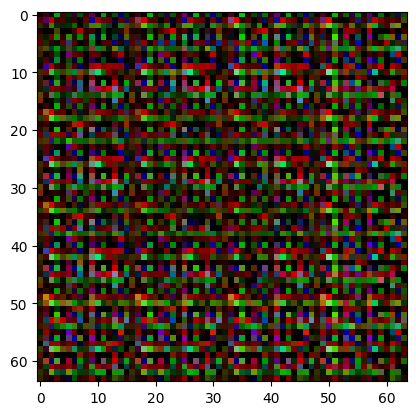

 72%|███████▏  | 36/50 [10:16<04:01, 17.23s/it]

epoch - : 35,Generator loss - : -2775.4047927856445, Discriminator - : -3297.5871810913077 , g_lr = 0.0001 , d_lr = 0.0001


 74%|███████▍  | 37/50 [10:33<03:42, 17.13s/it]

epoch - : 36,Generator loss - : -2809.252212524414, Discriminator - : -3353.8379455566387 , g_lr = 0.0001 , d_lr = 0.0001


 76%|███████▌  | 38/50 [10:51<03:26, 17.18s/it]

epoch - : 37,Generator loss - : -2843.437171936035, Discriminator - : -3402.206678771973 , g_lr = 0.0001 , d_lr = 0.0001


 78%|███████▊  | 39/50 [11:08<03:10, 17.29s/it]

epoch - : 38,Generator loss - : -2877.321357727051, Discriminator - : -3450.7393585205077 , g_lr = 0.0001 , d_lr = 0.0001


 80%|████████  | 40/50 [11:25<02:51, 17.15s/it]

epoch - : 39,Generator loss - : -2911.390914916992, Discriminator - : -3574.0996536254884 , g_lr = 0.0001 , d_lr = 0.0001


 82%|████████▏ | 41/50 [11:42<02:33, 17.09s/it]

epoch - : 40,Generator loss - : -2945.570182800293, Discriminator - : -3670.017671203612 , g_lr = 0.0001 , d_lr = 0.0001


 84%|████████▍ | 42/50 [12:00<02:17, 17.23s/it]

epoch - : 41,Generator loss - : -2979.7940826416016, Discriminator - : -3733.3040649414056 , g_lr = 0.0001 , d_lr = 0.0001
tensor(0.)      tensor(0.9474)


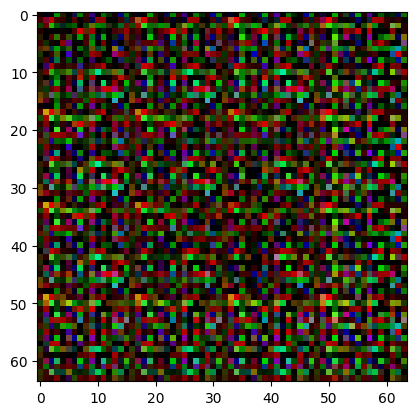

 86%|████████▌ | 43/50 [12:17<02:01, 17.30s/it]

epoch - : 42,Generator loss - : -3014.0742721557617, Discriminator - : -3799.0757263183614 , g_lr = 0.0001 , d_lr = 0.0001


 88%|████████▊ | 44/50 [12:35<01:44, 17.37s/it]

epoch - : 43,Generator loss - : -3048.340057373047, Discriminator - : -3846.7052825927717 , g_lr = 0.0001 , d_lr = 0.0001


 90%|█████████ | 45/50 [12:51<01:26, 17.21s/it]

epoch - : 44,Generator loss - : -3082.761405944824, Discriminator - : -3898.391964721681 , g_lr = 0.0001 , d_lr = 0.0001


 92%|█████████▏| 46/50 [13:08<01:08, 17.10s/it]

epoch - : 45,Generator loss - : -3117.2821044921875, Discriminator - : -3940.524584960938 , g_lr = 0.0001 , d_lr = 0.0001


 94%|█████████▍| 47/50 [13:25<00:51, 17.01s/it]

epoch - : 46,Generator loss - : -3151.803062438965, Discriminator - : -3997.5799896240223 , g_lr = 0.0001 , d_lr = 0.0001


 96%|█████████▌| 48/50 [13:42<00:34, 17.11s/it]

epoch - : 47,Generator loss - : -3186.2689666748047, Discriminator - : -4039.9275207519518 , g_lr = 0.0001 , d_lr = 0.0001


 98%|█████████▊| 49/50 [14:00<00:17, 17.21s/it]

epoch - : 48,Generator loss - : -3221.046745300293, Discriminator - : -4082.0992950439468 , g_lr = 0.0001 , d_lr = 0.0001
tensor(0.)      tensor(0.9787)


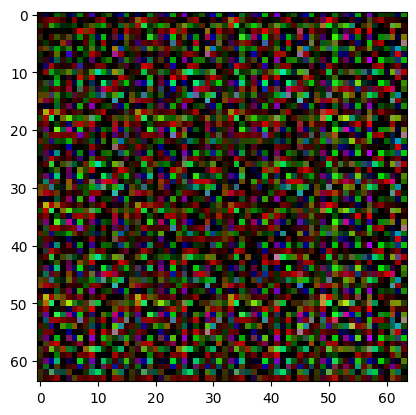

100%|██████████| 50/50 [14:17<00:00, 17.15s/it]

epoch - : 49,Generator loss - : -3255.726005554199, Discriminator - : -4116.342541503904 , g_lr = 0.0001 , d_lr = 0.0001


In [ ]:
print(ones.dtype)
generator.train()
discriminator.train()
feature_loss =  torch.nn.MSELoss()

for epoch in tqdm(range(epochs)):


  factor = factor*decay
  #print(epoch)
  epoch_count.append(epoch)
  generator_loss.append(0)
  discriminator_loss.append(0)
  discriminator_loss_part1.append(0)
  discriminator_loss_part2.append(0)
  feature_loss_list.append(0)
  penalty.append(0)
  fidlist.append(fid(samples_used , dataset , inception_model , generator).item())

  for batch_idx , (data) in enumerate(data_loader):
    if(batch_idx % itr == 0):
        generator.train()
        discriminator.eval()

        #print("gen----------------------------------------------" , batch_idx)
        batch_size = (data.shape[0])
        data = data.to(device)
        z = torch.normal(mean = 0 , std = 1 ,size = (batch_size , 1 , 16,16) ).to(device)
        discriminator_output_generated , discriminator_features_generated = discriminator(generator(z))
        discriminator_output_real, discriminator_features_real = discriminator(data)

        f_loss = feature_loss(discriminator_features_generated , discriminator_features_real)
        feature_loss_list[epoch] += f_loss.item()
        g_loss = torch.mean(-1*(discriminator_output_generated))

        g_loss = (1-factor)*g_loss+ factor*f_loss
        generator_loss[epoch] += torch.mean(g_loss).item()
        d_optim.zero_grad()

        g_optim.zero_grad()

        g_loss.backward()
        #torch.nn.utils.clip_grad_norm_(generator.parameters(), clip_value)
        g_optim.step()
    else:
        generator.eval()
        discriminator.train()
        #print("dis" , batch_idx)
        #print(batch_idx)
        batch_size = (data.shape[0])
        data = data.to(device)


        z = torch.normal(mean = 0 , std = 1 ,size = (batch_size , 1 , 16,16)).to(device)
        discriminator_output_real = discriminator(data)[0]
        discriminator_output_generated = discriminator(generator(z))[0]
        part1 = (discriminator_output_real)
        part2 = ( discriminator_output_generated)
        #d_loss = loss_func(discriminator_output_real, ones) + loss_func( discriminator_output_generated, zeroes)
        d_loss = torch.mean(-1*(part1 - part2))
        if(apply_grad_penalty):
            gp = coeff*compute_gp(batch , discriminator , data , generator(z))
            penalty[epoch] += gp.item()/(coeff*(itr-1))
            d_loss+= gp

        discriminator_loss[epoch] += (d_loss).item()/(itr -1)
        discriminator_loss_part1[epoch] += -1*torch.mean(part1).item()/(itr-1)

        discriminator_loss_part2[epoch] += torch.mean(part2).item()/(itr-1)
        d_optim.zero_grad()
        d_loss.backward()

        d_optim.step()

   #torch.nn.utils.clip_grad_norm_(generator.parameters(), clip_value)

    if(epoch%7 == 0):

        if(batch_idx == 0 ):
            img = generator(z)[0].to('cpu').detach()
            img  = img.permute(1,2,0)
            print(torch.min(img) , "    " , torch.max(img))
            plt.imshow(img)
            plt.show()

  #g_scheduler.step()
  #d_scheduler.step()



    #print(str(data.min()) + "   " + str(data.max()))
    #print(str(generator(z).min()) + "  " + str(generator(z).max()))

  print(f"epoch - : {epoch_count[epoch]},Generator loss - : {generator_loss[epoch]}, Discriminator - : {discriminator_loss[epoch]} , g_lr = {g_optim.param_groups[0]['lr']} , d_lr = {d_optim.param_groups[0]['lr']}")
  if(epoch%10 == 0):
      torch.save(generator.state_dict() , "generator " + str(epoch) + ".pth")
      torch.save(discriminator.state_dict() , "discriminator" + str(epoch) + ".pth" )

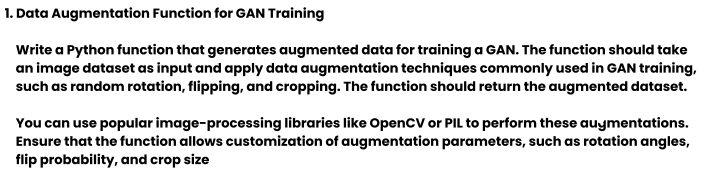

```python
from tf.keras.preprocessing.image import ImageDataGenerator
datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=3.0,
    height_shift_range=4.0,
    shear_range=3.0,
    zoom_range=3.0,,
)

datagenerator=datagen.flow_from_directory(directory,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
)

```

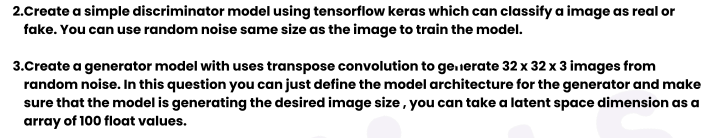

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model(input_shape=(32, 32, 3)):
    model = tf.keras.Sequential()

    # Convolutional layers to process input images
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())

    # Dense layer for classification
    model.add(layers.Dense(1))

    return model

# Example usage
discriminator = make_discriminator_model()
discriminator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()

    # Dense layer to map the input noise to a dense layer
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to a 3D volume
    model.add(layers.Reshape((8, 8, 256)))

    # Transpose convolutional layers to upsample the input
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Example usage
generator = make_generator_model()
generator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization (Batch  (None, 16384)             65536     
 Normalization)                                                  
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 128)        

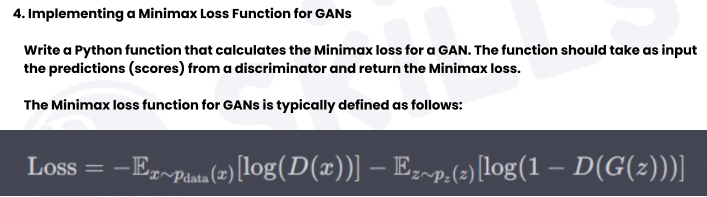

In [ ]:
import tensorflow as tf

def minimax_loss(discriminator_predictions_real, discriminator_predictions_fake):

    # Compute the log probability of the discriminator predicting real images as real
    loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(discriminator_predictions_real),
        logits=discriminator_predictions_real))

    # Compute the log probability of the discriminator predicting fake images as fake
    loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.zeros_like(discriminator_predictions_fake),
        logits=discriminator_predictions_fake))

    # Combine the losses
    minimax_loss = loss_real + loss_fake

    return minimax_loss


5.Use the models made in question 2,3 and make your own GAN model by connecting the generator and
the discriminator to generate images from random noise , You can use CIFAR -10 dataset. Find some
tips on creating your own GAN here :https://machinelearningmastery.com/how-to-code-generative-
adversarial-network-hacks/

Please note: Images are already generated from cifar10 dataset in question no. 2

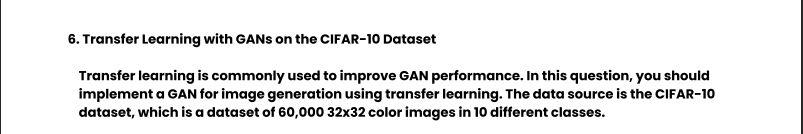

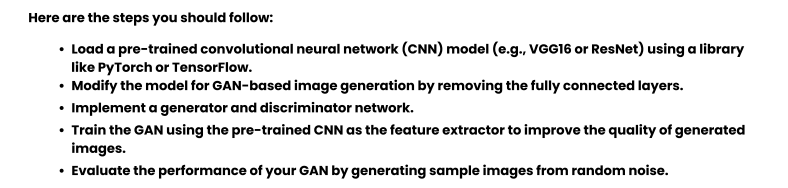

In [ ]:
import tensorflow as tf
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-yzw6mwlw
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-yzw6mwlw
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=e703973b4c5d7b43c07c4255628aba32fe6c250aa08087644a5a58d67ea13f95
  Stored in directory: /tmp/pip-ephem-wheel-cache-mtsp62wq/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [ ]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Input
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose, Input
from tensorflow.keras.models import Sequential

def make_generator_model():
    model = Sequential()
    model.add(Dense(256 * 8 * 8, activation="relu", input_dim=100))
    model.add(Reshape((8, 8, 256)))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation='tanh'))
    return model


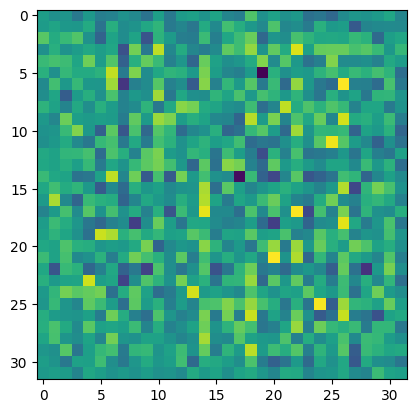

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dropout, Dense, LeakyReLU
from tensorflow.keras.models import Model, Sequential

def make_discriminator_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

94765736/94765736 [==============================] - 0s 0us/step
tf.Tensor([[0.399421]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

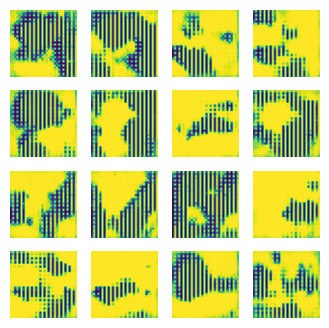

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-44-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-44-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


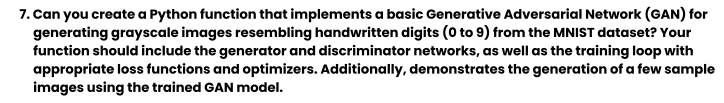

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-iqnm8qct
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-iqnm8qct
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

11490434/11490434 [==============================] - 0s 0us/step


tf.Tensor([[0.00341177]], shape=(1, 1), dtype=float32)


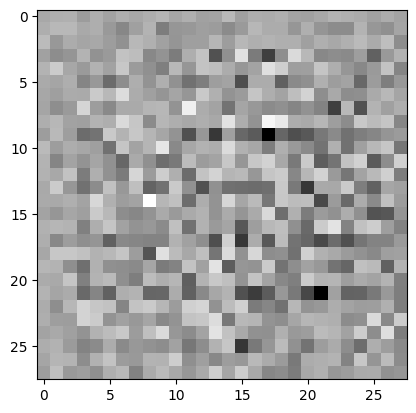

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

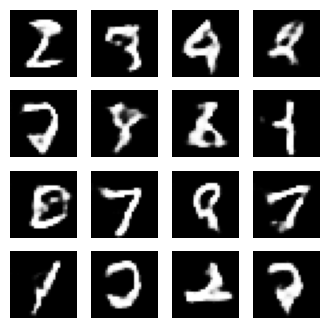

In [ ]:
train(train_dataset, EPOCHS)

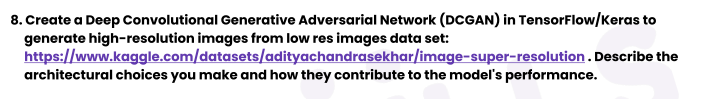

In [ ]:
! pip install kaggle

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir ~/.kaggled


!cp /content/drive/MyDrive/DataScience/kaggle.json ~/.kaggled/kaggle.json

! chmod 600 ~/.kaggled/kaggle.json

! kaggle datasets download adityachandrasekhar/image-super-resolution


In [ ]:
!unzip image-super-resolution.zip

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 143MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadloc

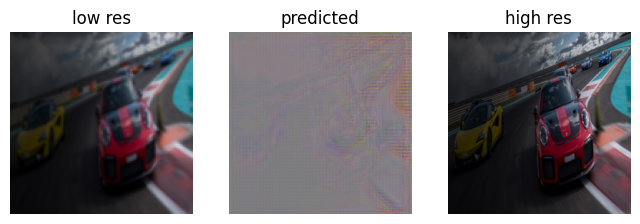

epoch  1 / 180


  0%|          | 0/35 [00:00<?, ?it/s]

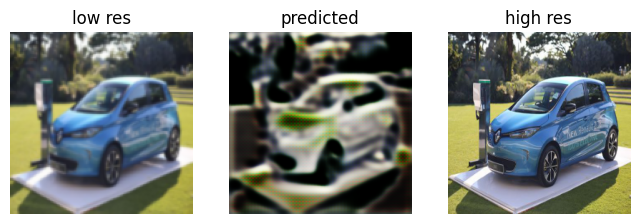

epoch  2 / 180


  0%|          | 0/35 [00:00<?, ?it/s]

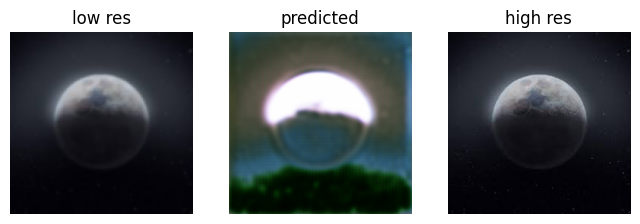

epoch  3 / 180


  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

# Define the transformations on the data
low_res_size = 128
high_res_size = 256
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
denormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])

class ImageDataset(Dataset):
    # This is a custom dataset created using pytorch Dataset
    def __init__(self, root_dir):
        super(ImageDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "low_res"))
        files_high = os.listdir(os.path.join(root_dir, "high_res"))
        self.data = list(zip(files_low, files_high))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]

        # Get the path for the image LR and HR
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)
        # Open the actual image
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))

        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]

        # Apply the transformation to the image
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)

        return low_res, high_res

device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
epochs = 180
batch_size = 16
num_workers = 2
img_channels = 3

# listing the model to take the required subset of it
test_vgg_model = vgg19(weights=True).eval().to(device)
lf = list(test_vgg_model.features)
lf[25]

class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(
            self,
            in_channels,
            out_channels,
            use_activation=True,
            use_BatchNorm=True,
            **kwargs
    ):
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor * 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature
        self.blocks = nn.Sequential(*blocks)
        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

def plot_examples(gen):
    dataset_test = ImageDataset(root_dir="./dataset/val")
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)

            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")
            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))

            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")

            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")

            if(idx == 1):
                break

    # Show the figure
    plt.show()

    gen.train()

gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

# the data loaders for training and validation
train_data = ImageDataset(root_dir="./dataset/train")
train_data_len = int(len(train_data) * 0.8)
val_data_len = len(train_data) - train_data_len
train_data, val_data = torch.utils.data.random_split(train_data, [train_data_len, val_data_len])

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)

test_data = ImageDataset(root_dir="./dataset/val")
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0
    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)

        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())

        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))

        disc_loss = disc_loss_fake + disc_loss_real
        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()
        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

# Training and validation loss lists
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    plot_examples(gen)
    print("epoch ", epoch+1, "/", epochs)

    gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)

    # Validation loop
    with torch.no_grad():
        val_loss = 0
        for low_res, high_res in val_loader:
            high_res = high_res.to(device)
            low_res = low_res.to(device)

            fake = gen(low_res)
            loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
            val_loss += loss_for_vgg.item()

        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)
        train_loss_list.append(gen_loss.item())

    if epoch % 5 == 0:
        torch.save(gen.state_dict(), "./gen.pth")
        torch.save(disc.state_dict() ,  "./disc.pth")

plot_examples(gen)

# Plot training and validation loss
plt.figure(figsize=(10, 7))
plt.plot(train_loss_list, color='orange', label='train loss')
plt.plot(val_loss_list, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(gen, "./resolution")

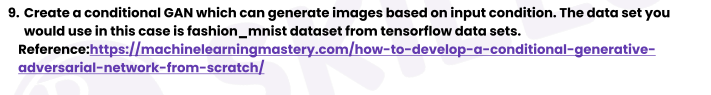

In [ ]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 7ms/step
>26, 279/468, d1=0.684, d2=0.668 g=0.855
2/2 [==============================] - 0s 7ms/step
>26, 280/468, d1=0.658, d2=0.681 g=0.896
2/2 [==============================] - 0s 7ms/step
>26, 281/468, d1=0.709, d2=0.686 g=0.858
2/2 [==============================] - 0s 7ms/step
>26, 282/468, d1=0.674, d2=0.613 g=0.876
2/2 [==============================] - 0s 7ms/step
>26, 283/468, d1=0.745, d2=0.683 g=0.827
2/2 [==============================] - 0s 7ms/step
>26, 284/468, d1=0.675, d2=0.674 g=0.859
2/2 [==============================] - 0s 6ms/step
>26, 285/468, d1=0.703, d2=0.729 g=0.833
2/2 [==============================] - 0s 7ms/step
>26, 286/468, d1=0.704, d2=0.706 g=0.877
2/2 [==============================] - 0s 7ms/step
>26, 287/468, d1=0.696, d2=0.697 g=0.863
2/2 [==============================] - 0s 8ms/step
>26, 288/468, d1=0.754, d2=0.642 g=0.864
2/2 [========================

# The End